# Further Explore MovieLens Ratings

Since so much of the project revolves around the user ratings, this notebook explores the data in `ratings.csv` more closely. Since this is such a huge dataset (over 20 million ratings), it is just as illuminating to perform this for the reduced dataset (`ml-latest-small.zip` found [here](ml-latest-small.zip)) included in this repository.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

## Load/shape ratings

In [2]:
ratings = pd.read_csv('data/ratings.csv')
print(len(ratings))
ratings.head()

100004


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


The formatting of this data isn't particularly helpful for our purposes. Instead of one long column, it would make more sense to have each user presented as a row and the different movies as columns, with their ratings propagating the dataframe.  Since the timestamp isn't particularly helpful at this time, we will do this by using `pivot_table` in `pandas`

In [3]:
ratings = ratings.pivot_table(index='userId',columns='movieId',values='rating')
print(ratings.shape)
ratings.head()

(671, 9066)


movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This is presented in a much more useful format.  Now we can easily apply vector/matrix calculations to the data and significantly reduce computation time.

We now have a reduced data set of 671 users rating a total of 9066 movies, with a total of 100004 individual ratings.

## Sparsity of ratings

The first thing to note is that our data looks very sparse.  We can compute the fraction of cells that are populated (we fill the NaNs of the table with 0.0 for convenience)

In [4]:
ratings.fillna(value=0.0, inplace=True)
sparsity = np.sum(ratings.astype(bool).sum(axis=1))
sparsity /= np.prod(ratings.shape)
sparsity

0.016439141608663475

This means in the 671x9066 matrix, about 1.6% of the entries are filled in.  Very sparse, but considering users (rows) are only required to have a minimum of 20 entries this isn't bad.

In [5]:
20*ratings.shape[0]/np.prod(ratings.shape)

0.0022060445621001545

## Ratings per user/movie
We can also compute how many ratings each user/show has and make a histogram of those values

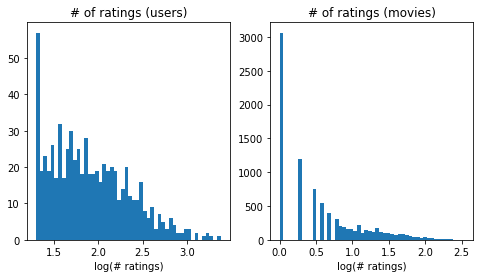

In [6]:
n_user_ratings = ratings.astype(bool).sum(axis=1)
n_movie_ratings = ratings.astype(bool).sum(axis=0)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(np.log10(n_user_ratings), bins=50)
plt.title('# of ratings (users)')
plt.xlabel('log(# ratings)')

plt.subplot(1,2,2)
plt.hist(np.log10(n_movie_ratings), bins=50)
plt.title('# of ratings (movies)')
plt.xlabel('log(# ratings)');

These plots are pretty illuminating.  We can see that:
* the defined minima for the dataset &mdash; each user has at least 20 ratings, each movie at least 1 rating
* most users fall in <~300 ratings, but some make it all the way to have over 2000
* most movies have <~10 ratings, but some have a few hundred

## Most user ratings

In [7]:
idx = n_user_ratings.idxmax()
nmax = n_user_ratings.max()
idx, nmax

(547, 2391)

It seems the user who rated the most movies did so for nearly 2400! We can see the distribution of their ratings

Average rating: 3.3667921371810956
Median rating: 3.5


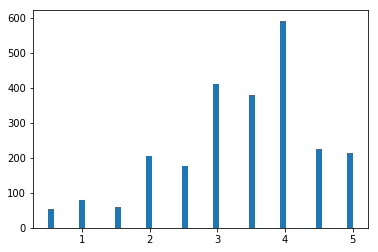

In [8]:
user_ratings = ratings.loc[idx][ratings.loc[idx]>0]
print("Average rating: "+str(np.mean(user_ratings)))
print("Median rating: "+str(np.median(user_ratings)))
plt.hist(user_ratings[user_ratings>0], bins=50);

In an unscientific fashion, this looks like an authentic rater and not just someone who rated many movies at a similar level.

## Most movie ratings

In [9]:
idx_movie = n_movie_ratings.idxmax()
nmax_movie = n_movie_ratings.max()
idx_movie, nmax_movie

(356, 341)

This movie got 341 ratings as the most-rated movie. We can use `movies.csv` to map the movieId to a title

In [10]:
movies = pd.read_csv('data/movies.csv', index_col='movieId')
movies.loc[idx_movie]

title          Forrest Gump (1994)
genres    Comedy|Drama|Romance|War
Name: 356, dtype: object

Forrest Gump, which makes perfect sense as the most-rated movie in the dataset.  Just out of curiosity, let's see what our most-ratings user gave the movie

Jeez, such a critic. Let's see the average for Forrest Gump

In [11]:
np.mean(ratings[idx_movie][ratings[idx_movie] > 0])

4.05425219941349

More respectable.